In [2]:
import tensorflow as tf
import os, pickle, sys, time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from utils.MyRAN56_v2 import ResidualAttentionModel_56
from contextlib import redirect_stdout

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print(gpus)

1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
path = './models'
model_name = '/ran56_v2'
model_path = path + model_name
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print(model_path)
else:
    print(model_path + ' already exists.')

history_path = model_path + '/history'
if not os.path.exists(history_path):
    os.makedirs(history_path)
    print(history_path)
else:
    print(history_path + ' already exists.')

saved_model_path = model_path + '/saved_models'
if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)
    print(saved_model_path)
else:
    print(saved_model_path + ' already exists.')

graph_path = model_path + '/graphs'
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
    print(graph_path)
else:
    print(graph_path + ' already exists.')

./models/ran56_v2 already exists.
./models/ran56_v2/history already exists.
./models/ran56_v2/saved_models already exists.
./models/ran56_v2/graphs already exists.


In [5]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2,
                                                          horizontal_flip=True,
                                                          validation_split=0.2)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# train_mean = np.mean(X_train, axis=(0,1,2))
# train_std = np.std(X_train, axis=(0,1,2))
# np.save("train_mean.npy", train_mean)
# np.save("train_std.npy", train_std)

train_mean = np.load("train_mean.npy")
train_std = np.load("train_std.npy")



In [7]:

# X_train = X_train - X_train.mean()
# X_test = X_test - X_test.mean()

# datagen.fit(X_train)

X_train = (X_train - train_mean) / train_std
# X_test = (X_test - X_test.mean())

# We can't use the test set's information at all, that would be biasing the results. So we must use the train set's mean and std to normalize.
X_test = (X_test - train_mean) / train_std

datagen.fit(X_train)


In [8]:
input_shape = X_train.shape[1:]
output_classes = 10

ran56 = ResidualAttentionModel_56(input_shape, output_classes, learning_type='NAL')

model = ran56.return_Model()

model.compile(tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Model_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1_In (Conv2D)              (None, 32, 32, 32)   864         ['Model_Input[0][0]']            
                                                                                                  
 BN_In (BatchNormalization)     (None, 32, 32, 32)   128         ['Conv1_In[0][0]']               
                                                                                                  
 ReLU_In (Activation)           (None, 32, 32, 32)   0           ['BN_In[0][0]']                  
                                                                                              

In [9]:
global summary_filename 
summary_filename = graph_path + '/{}'.format(model_name[1:]) + '_modelsummary.txt'
print(summary_filename)

./models/ran56_v2/graphs/ran56_v2_modelsummary.txt


In [10]:
with open(summary_filename, 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [11]:
# dot_img_file = '/tmp/ran56.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

# earlyStopping_TrainAcc = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
# callbacks = list()
# callbacks.append(earlyStopping_TrainAcc)

callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='accuracy'),
          tf.keras.callbacks.ReduceLROnPlateau(patience=5,  monitor='loss')]  


In [12]:
ran56_v2_history = model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'), validation_data=datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
                    epochs=200, callbacks=callbacks)

Epoch 1/200
625/625 [==============================] - 92s 131ms/step - loss: 1.7901 - accuracy: 0.3168 - val_loss: 1.8217 - val_accuracy: 0.3495 - lr: 0.0010
Epoch 2/200
625/625 [==============================] - 80s 128ms/step - loss: 1.4593 - accuracy: 0.4640 - val_loss: 1.7711 - val_accuracy: 0.4108 - lr: 0.0010
Epoch 3/200
625/625 [==============================] - 80s 127ms/step - loss: 1.2932 - accuracy: 0.5312 - val_loss: 1.4753 - val_accuracy: 0.5121 - lr: 0.0010
Epoch 4/200
625/625 [==============================] - 79s 126ms/step - loss: 1.1777 - accuracy: 0.5773 - val_loss: 1.7737 - val_accuracy: 0.4894 - lr: 0.0010
Epoch 5/200
625/625 [==============================] - 80s 129ms/step - loss: 1.0822 - accuracy: 0.6126 - val_loss: 1.1283 - val_accuracy: 0.5941 - lr: 0.0010
Epoch 6/200
625/625 [==============================] - 86s 138ms/step - loss: 1.0097 - accuracy: 0.6404 - val_loss: 1.3706 - val_accuracy: 0.5906 - lr: 0.0010
Epoch 7/200
625/625 [=========================

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [15]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
y_true = np.argmax(y_test,axis=1)



In [16]:
acc = accuracy_score(y_true, preds)
cr=  classification_report(y_true, preds)
print(f"Accuracy: {acc}")
print(cr)


Accuracy: 0.9207
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1000
           1       0.94      0.97      0.96      1000
           2       0.90      0.91      0.90      1000
           3       0.87      0.85      0.86      1000
           4       0.92      0.92      0.92      1000
           5       0.93      0.83      0.88      1000
           6       0.90      0.96      0.93      1000
           7       0.95      0.94      0.94      1000
           8       0.96      0.94      0.95      1000
           9       0.92      0.95      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [19]:
plot_loss_filename = graph_path + '/ran56_v2_Loss.png'
print(plot_loss_filename)
plot_acc_filename = graph_path + '/ran56_v2_Accuracy.png'
print(plot_acc_filename)

./models/ran56_v2/graphs/ran56_v2_Loss.png
./models/ran56_v2/graphs/ran56_v2_Accuracy.png


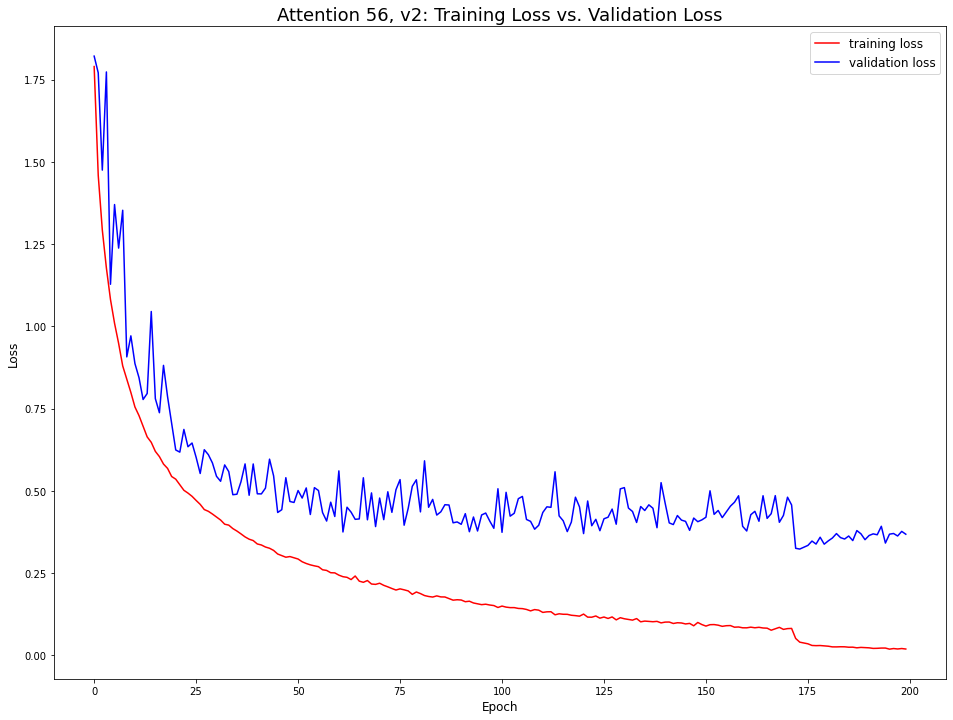

In [20]:
plt.figure(figsize=(16,12))
plt.title("Attention 56, v2: Training Loss vs. Validation Loss", fontsize=18)
plt.plot(ran56_v2_history.history['loss'], label='training loss', color='red')
plt.plot(ran56_v2_history.history['val_loss'], label = 'validation loss', color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_loss_filename)
plt.show()

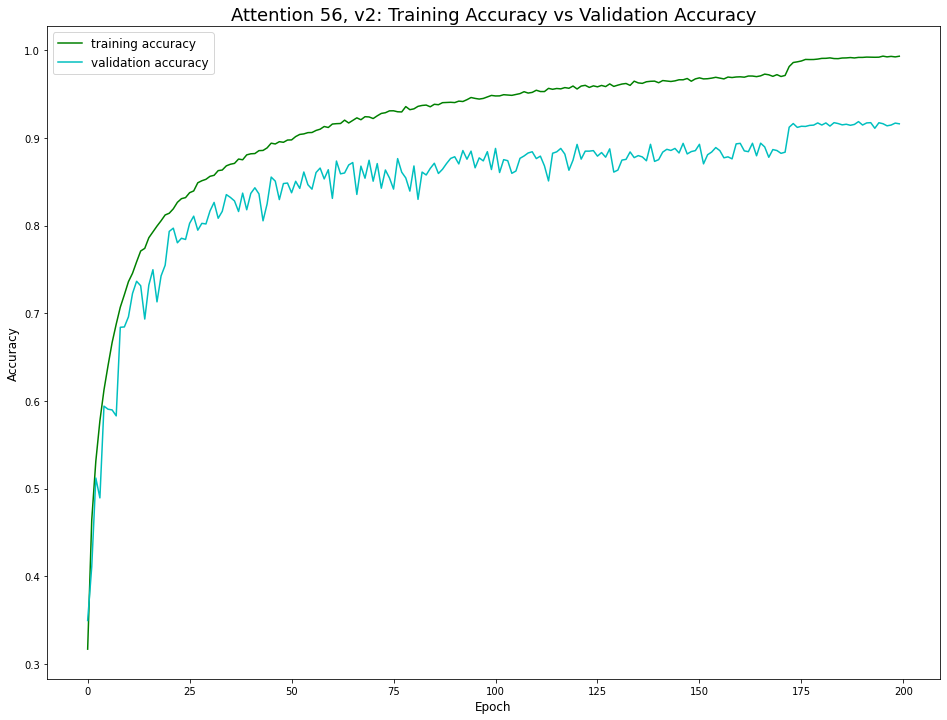

In [21]:
plt.figure(figsize=(16,12))
plt.title("Attention 56, v2: Training Accuracy vs Validation Accuracy", fontsize=18)
plt.plot(ran56_v2_history.history['accuracy'], label='training accuracy', color='g')
plt.plot(ran56_v2_history.history['val_accuracy'], label = 'validation accuracy', color='c')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_acc_filename)
plt.show()

In [22]:
history_filename = history_path + '/ran56_v2_history_' + time.ctime().replace(' ','_').replace(':','_')
print(history_filename)

./models/ran56_v2/history/ran56_v2_history_Mon_Dec_20_00_15_41_2021


In [23]:
np.save(history_filename+'.npy', ran56_v2_history.history)

In [26]:
# ran56_v2_history=np.load(history_filename+'.npy', allow_pickle='TRUE').item()

In [13]:
model.save(saved_model_path + '/ran56_v2')

INFO:tensorflow:Assets written to: ./models/ran56_v2/saved_models/ran56_v2\assets


INFO:tensorflow:Assets written to: ./models/ran56_v2/saved_models/ran56_v2\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
